In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("../dataset/heart.csv")
data.shape

(918, 12)

In [3]:
data.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N     0.00       Up             0  
1              N     1.00     Flat             1  
2              N     0.00       Up             0  
3              Y     1.50     Flat             1  
4              N     0.00       Up             0

Drop the patient ID since it's not important

In [4]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


We are using two approaches: either we treat the nan values in 'Systemic Illness' as 'none', indicating the patient didn't have any systemic illness, or we treat them as nan values that we should drop

We're gonna try dropping them first and see how the model behaves.

<Axes: >

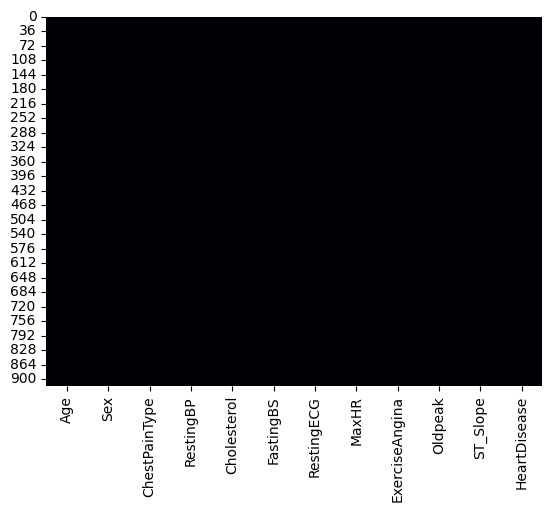

In [6]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False)

Now we will do one-hot encoding on "Systemic Illness", the the mapping to change the values to 0 and 1

In [7]:
data.describe().T

count   mean    std   min    25%    50%    75%    max
Age          918.00  53.51   9.43 28.00  47.00  54.00  60.00  77.00
RestingBP    918.00 132.40  18.51  0.00 120.00 130.00 140.00 200.00
Cholesterol  918.00 198.80 109.38  0.00 173.25 223.00 267.00 603.00
FastingBS    918.00   0.23   0.42  0.00   0.00   0.00   0.00   1.00
MaxHR        918.00 136.81  25.46 60.00 120.00 138.00 156.00 202.00
Oldpeak      918.00   0.89   1.07 -2.60   0.00   0.60   1.50   6.20
HeartDisease 918.00   0.55   0.50  0.00   0.00   1.00   1.00   1.00

Mapping to 0 and 1

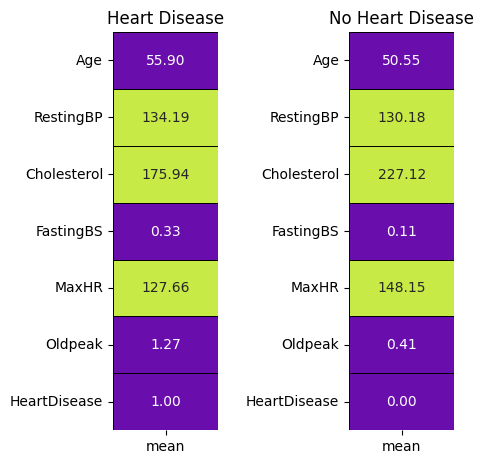

In [8]:
yes = data[data['HeartDisease'] == 1].describe().T
no = data[data['HeartDisease'] == 0].describe().T
colors = ['#6A0DAD', '#C7EA46']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (5, 5))
plt.subplot(1, 2, 1)
sns.heatmap(yes[['mean']], annot = True, cmap=colors, linewidths=0.4, linecolor='black', cbar=False, fmt='.2f',)
plt.title('Heart Disease')

plt.subplot(1,2,2)
sns.heatmap(no[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Heart Disease')

fig.tight_layout(pad=2)

In [9]:
col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features: ', *categorical_features)
print('Numerical Features: ', *numerical_features)


Categorical Features:  Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features:  Age RestingBP Cholesterol MaxHR Oldpeak


We could consider to drop 'Swollen Tonsils' because it has low correlation, but let's observe how the model performs

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1 = data.copy(deep = True)

df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])

The data is inbalanced, so we will observe how the model behaves and then decide if we need to do undersampling

Text(0.5, 1.0, 'Distribution : HeartDisease')

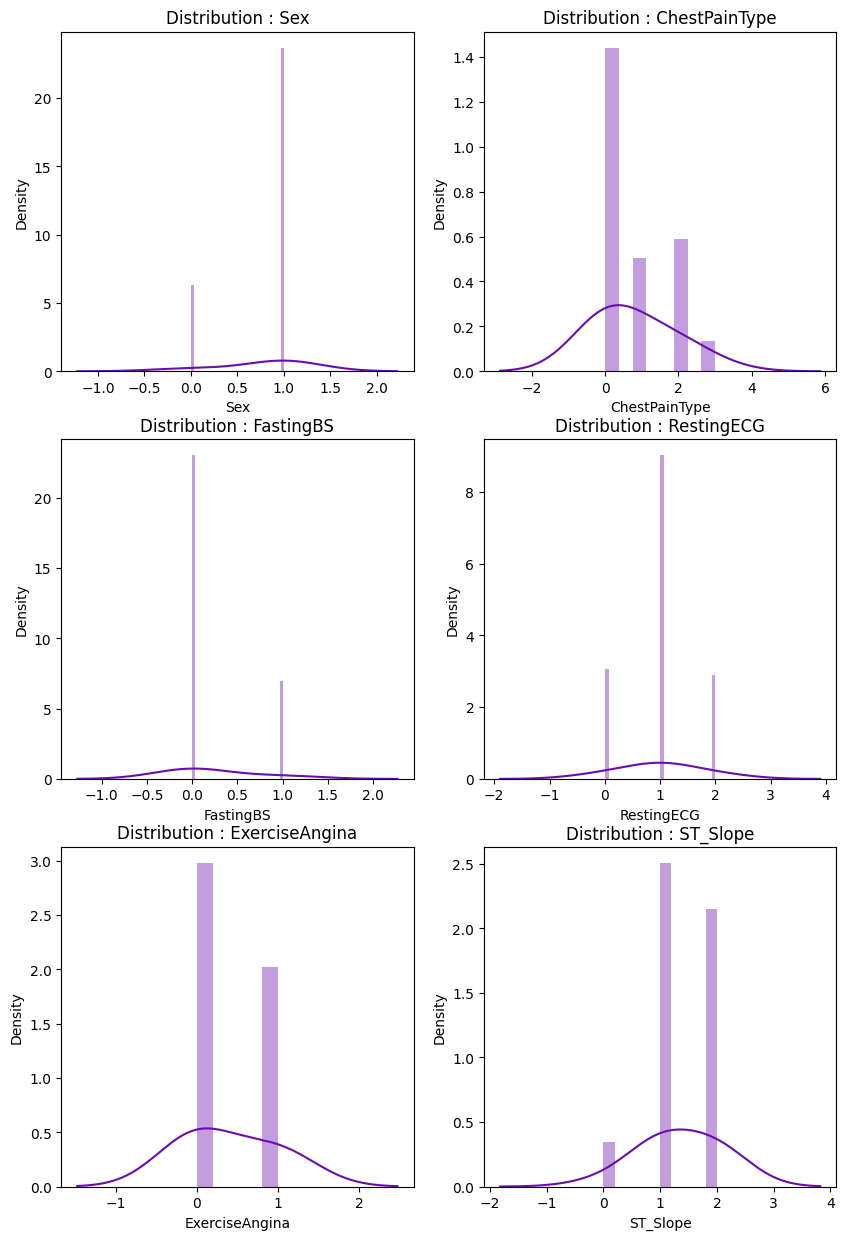

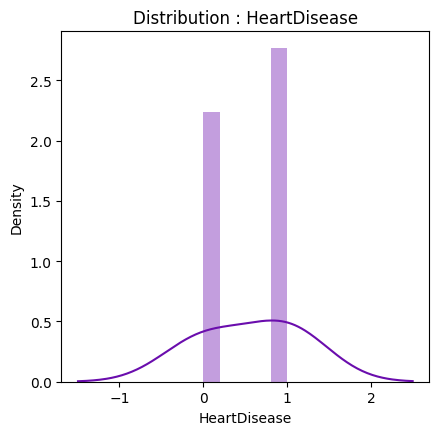

In [11]:
fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (10,15))
for i in range(len(categorical_features) - 1):
    plt.subplot(3,2,i+1)
    sns.distplot(df1[categorical_features[i]],kde_kws = {'bw' : 1},color = colors[0]);
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)
    
plt.figure(figsize = (4.75,4.55))
sns.distplot(df1[categorical_features[len(categorical_features) - 1]],kde_kws = {'bw' : 1},color = colors[0])
title = 'Distribution : ' + categorical_features[len(categorical_features) - 1]
plt.title(title)

Good enough, then build the model

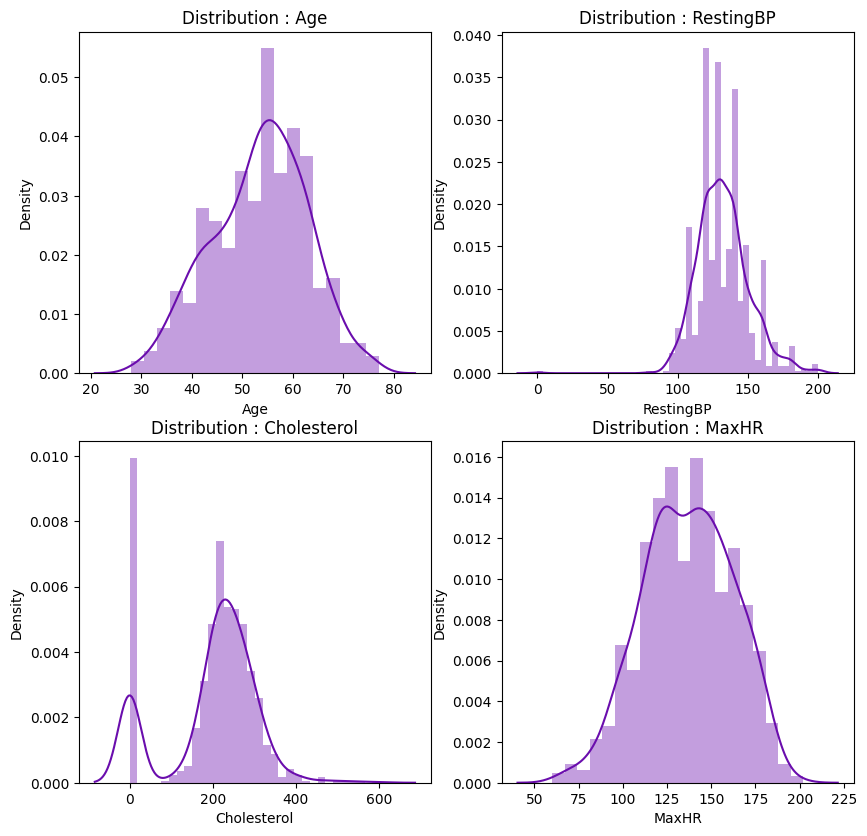

Text(0.5, 1.0, 'Distribution : Oldpeak')

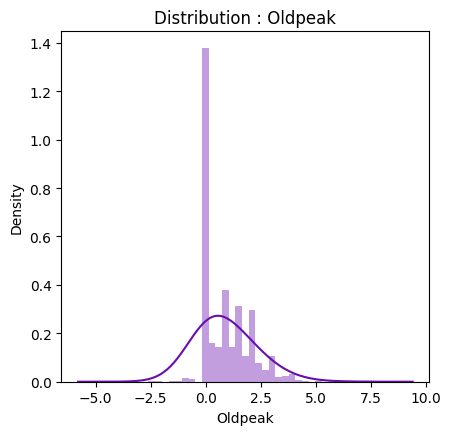

In [12]:
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (10,9.75))
for i in range(len(numerical_features) - 1):
    plt.subplot(2,2,i+1)
    sns.distplot(data[numerical_features[i]],color = colors[0])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

plt.figure(figsize = (4.75,4.55))
sns.distplot(df1[numerical_features[len(numerical_features) - 1]],kde_kws = {'bw' : 1},color = colors[0])
title = 'Distribution : ' + numerical_features[len(numerical_features) - 1]
plt.title(title)

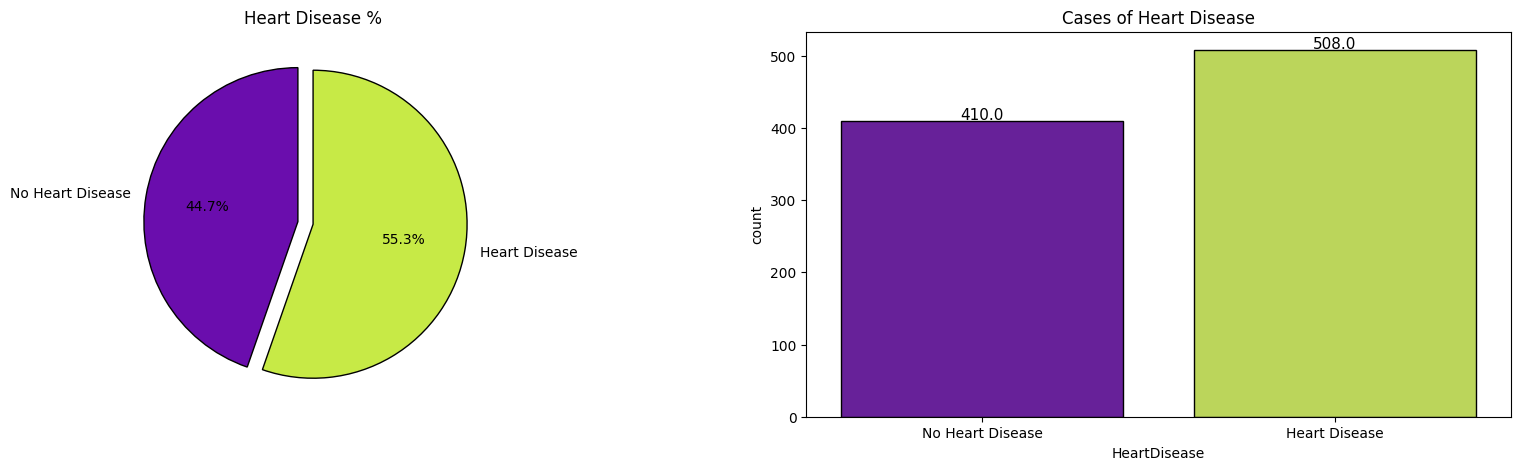

In [13]:
l = list(data['HeartDisease'].value_counts())
circle = [l[1] / sum(l) * 100, l[0] / sum(l) * 100]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.pie(circle, labels=['No Heart Disease', 'Heart Disease'], autopct='%1.1f%%', startangle=90, explode=(0.1, 0), colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Heart Disease %')

plt.subplot(1, 2, 2)
ax = sns.countplot(x='HeartDisease', data=data, palette=colors, edgecolor='black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize=11)
ax.set_xticklabels(['No Heart Disease', 'Heart Disease'])
plt.title('Cases of Heart Disease')

plt.show()


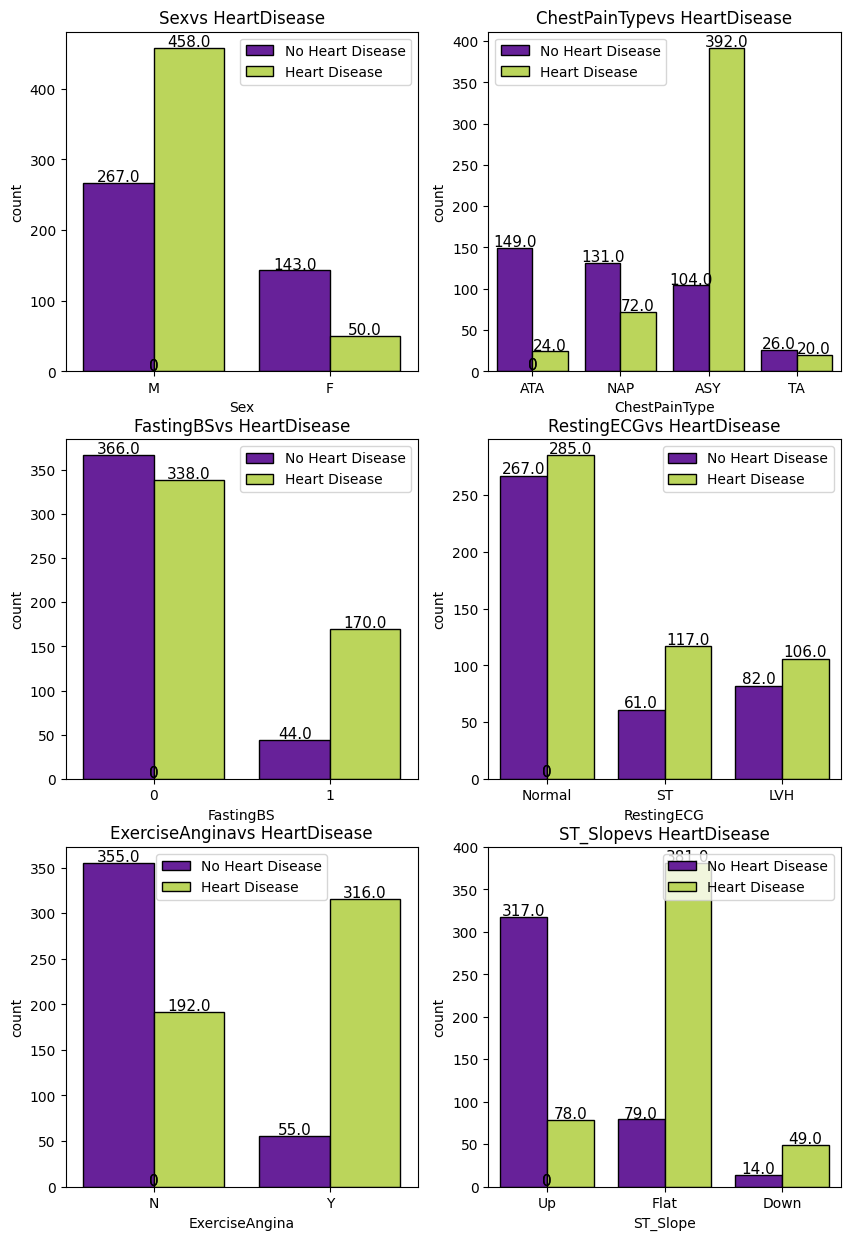

In [14]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for i in range(len(categorical_features) - 1):
    plt.subplot(3, 2, i+1)
    ax = sns.countplot(x = categorical_features[i], data = data, hue = "HeartDisease", palette = colors, edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment = 'center', fontsize = 11)
    title = categorical_features[i] + "vs HeartDisease"
    plt.legend(['No Heart Disease', 'Heart Disease'])
    plt.title(title)

In [15]:
sex = data[data['HeartDisease'] == 1]['Sex'].value_counts()
sex = [sex[0] / sum(sex) * 100, sex[1] / sum(sex) * 100]

cp = data[data['HeartDisease'] == 1]['ChestPainType'].value_counts()
cp = [cp[0] / sum(cp) * 100,cp[1] / sum(cp) * 100,cp[2] / sum(cp) * 100,cp[3] / sum(cp) * 100]

fbs = data[data['HeartDisease'] == 1]['FastingBS'].value_counts()
fbs = [fbs[0] / sum(fbs) * 100,fbs[1] / sum(fbs) * 100]

restecg = data[data['HeartDisease'] == 1]['RestingECG'].value_counts()
restecg = [restecg[0] / sum(restecg) * 100,restecg[1] / sum(restecg) * 100,restecg[2] / sum(restecg) * 100]

exang = data[data['HeartDisease'] == 1]['ExerciseAngina'].value_counts()
exang = [exang[0] / sum(exang) * 100,exang[1] / sum(exang) * 100]

slope = data[data['HeartDisease'] == 1]['ST_Slope'].value_counts()
slope = [slope[0] / sum(slope) * 100,slope[1] / sum(slope) * 100,slope[2] / sum(slope) * 100]

Text(0.5, 1.0, 'ST_Slope')

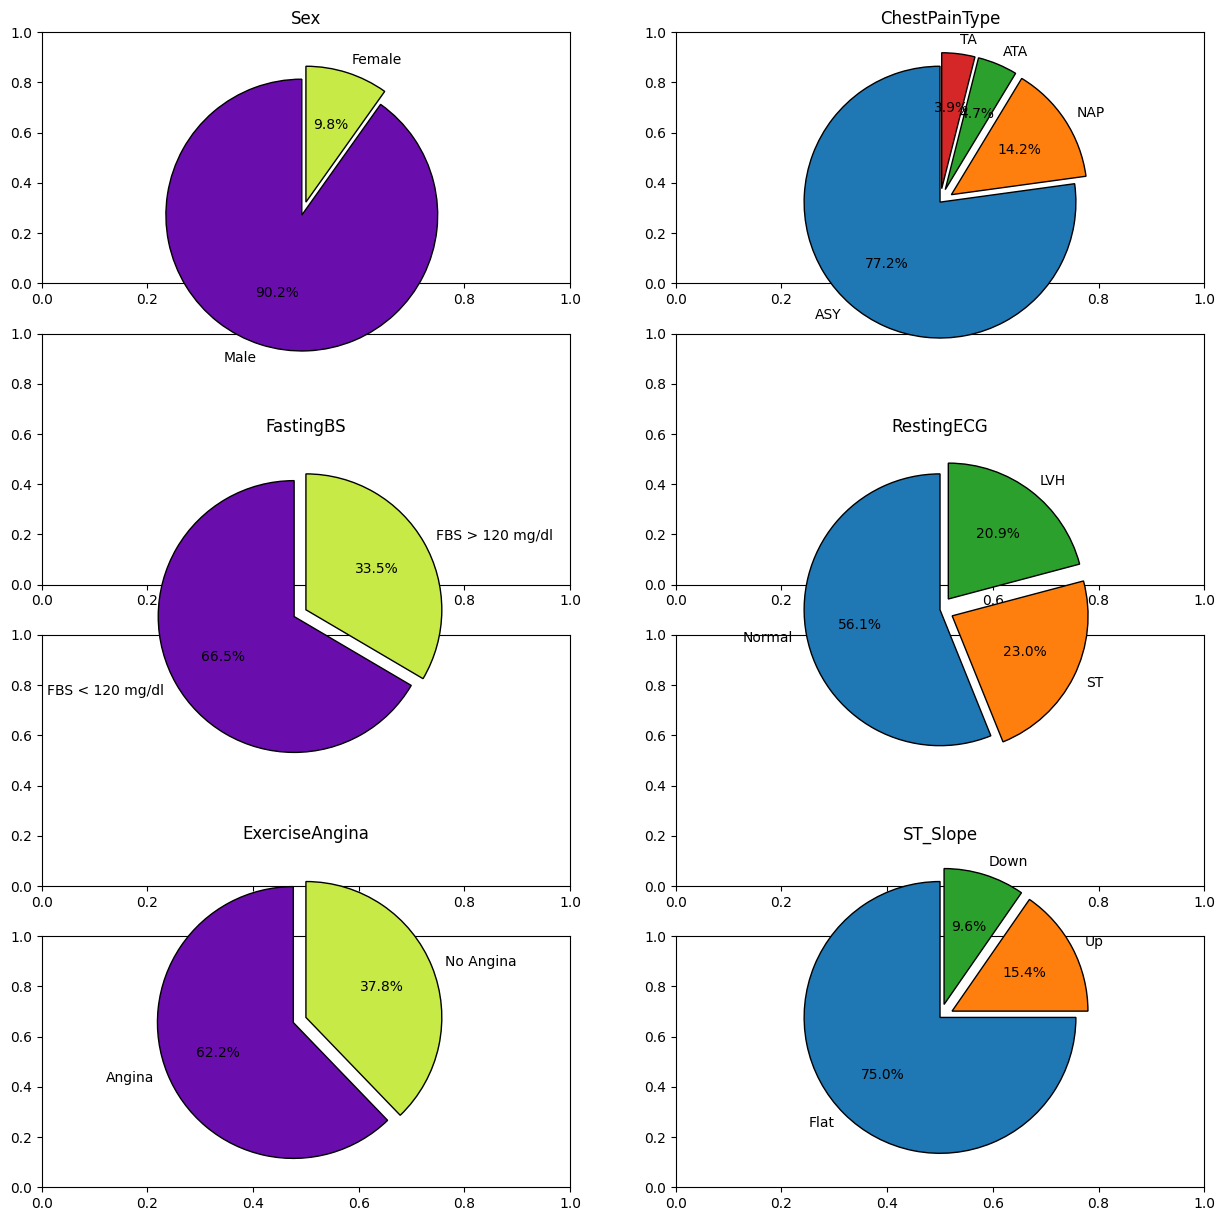

In [16]:
ax,fig = plt.subplots(nrows = 4,ncols = 2,figsize = (15,15))

plt.subplot(3,2,1)
plt.pie(sex,labels = ['Male','Female'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Sex')

plt.subplot(3,2,2)
plt.pie(cp,labels = ['ASY', 'NAP', 'ATA', 'TA'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ChestPainType')

plt.subplot(3,2,3)
plt.pie(fbs,labels = ['FBS < 120 mg/dl','FBS > 120 mg/dl'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('FastingBS')

plt.subplot(3,2,4)
plt.pie(restecg,labels = ['Normal','ST','LVH'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('RestingECG')

plt.subplot(3,2,5)
plt.pie(exang,labels = ['Angina','No Angina'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ExerciseAngina')

plt.subplot(3,2,6)
plt.pie(slope,labels = ['Flat','Up','Down'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1,0.1),
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('ST_Slope')

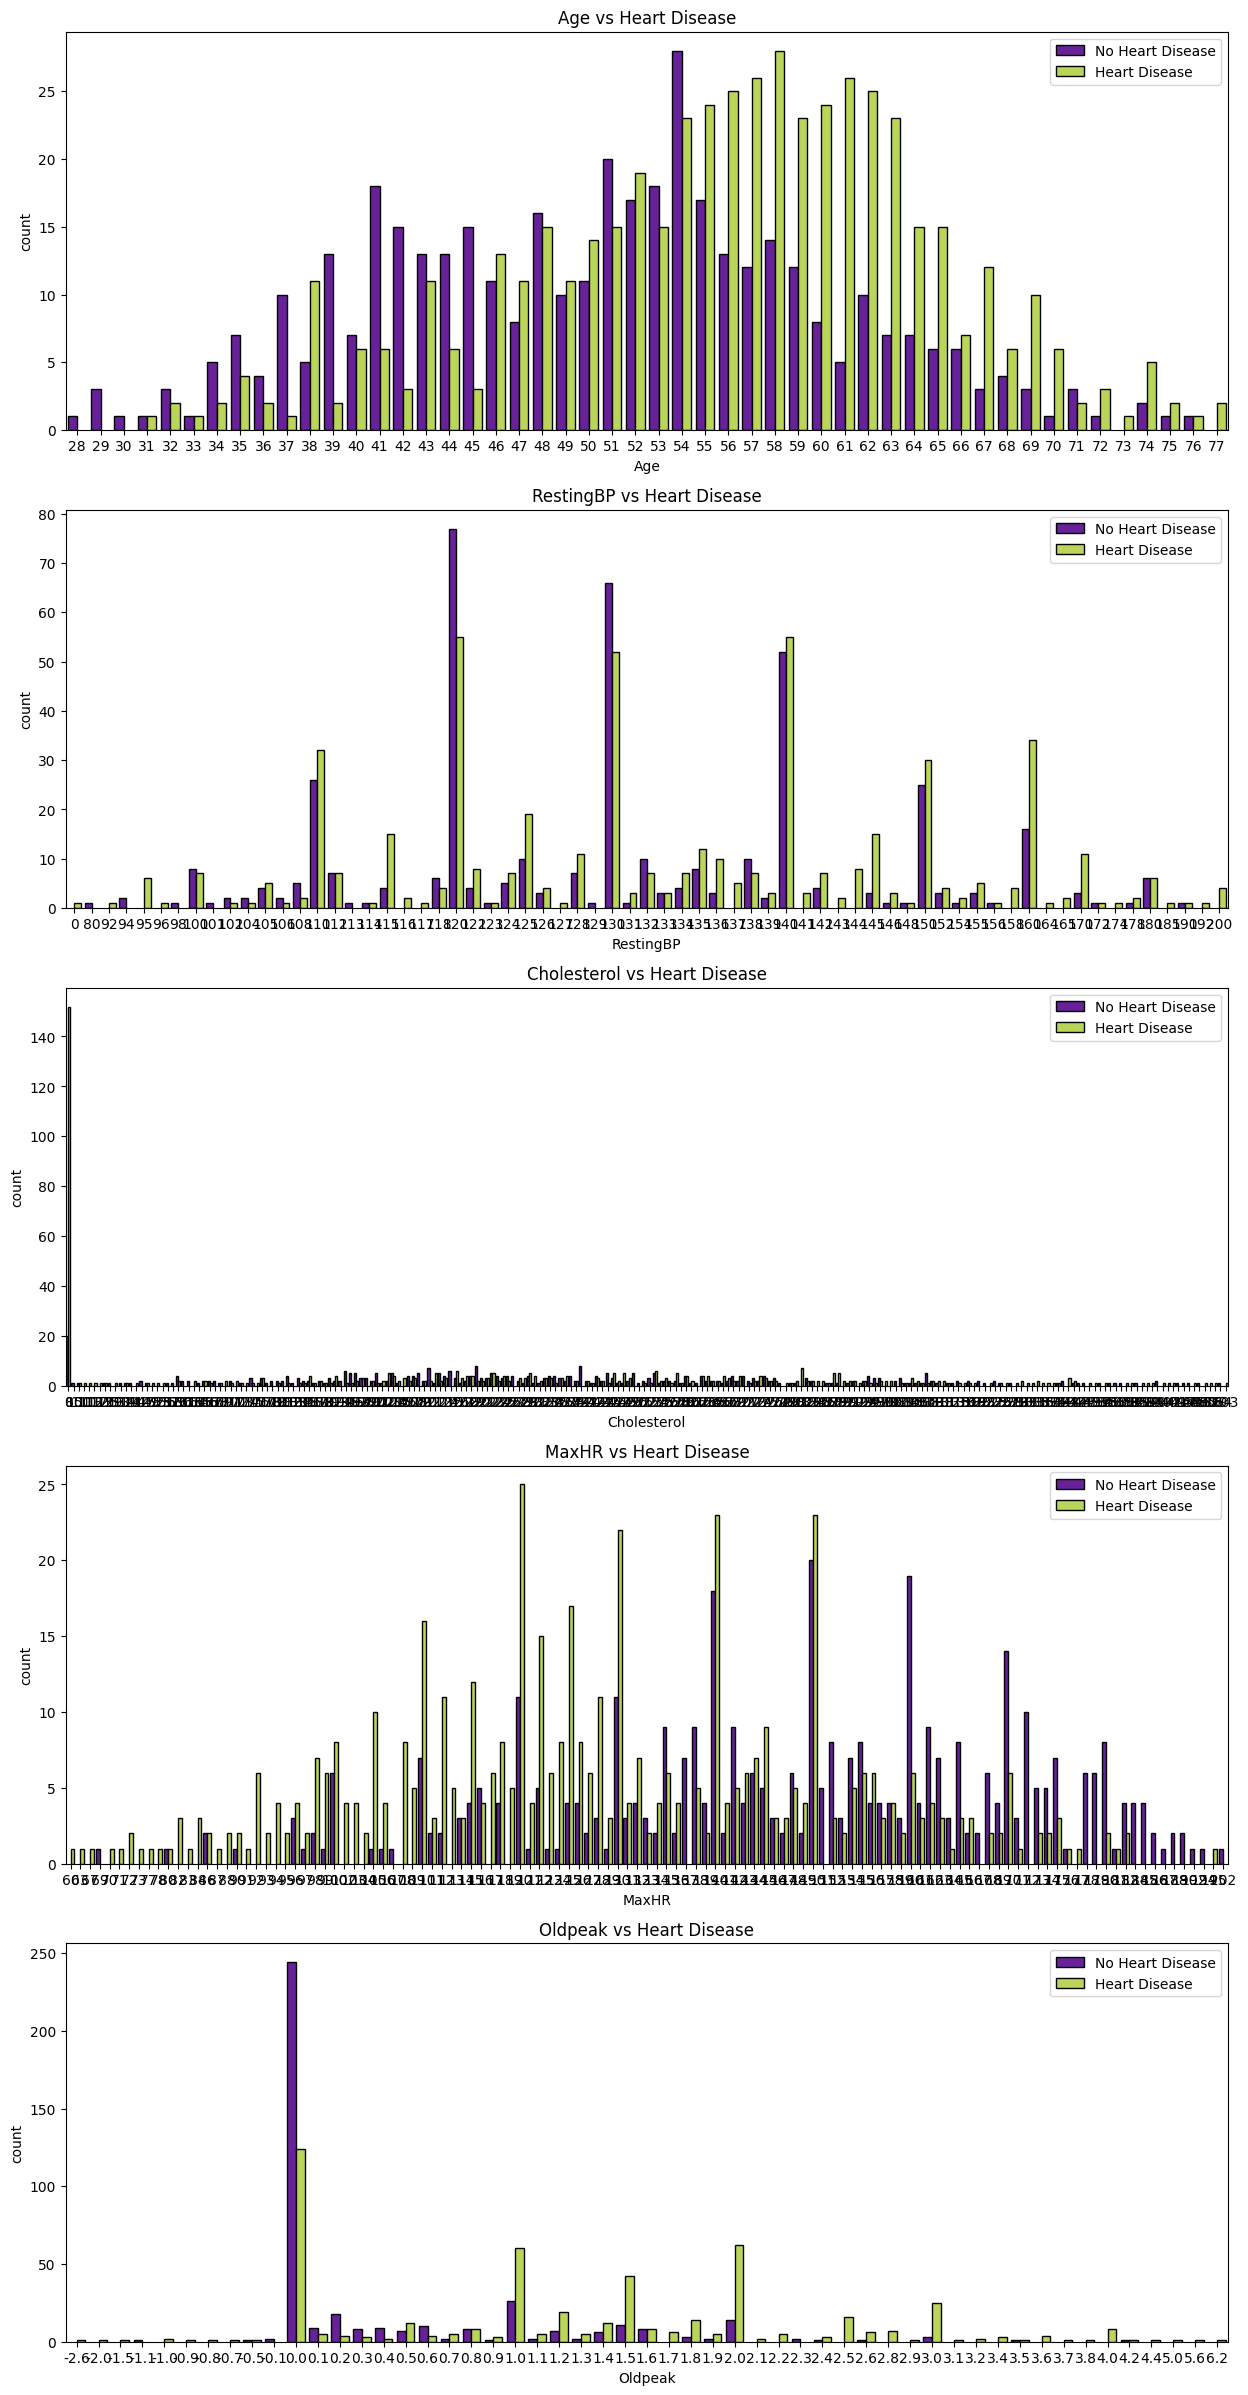

In [17]:
fig, ax = plt.subplots(nrows = 5,ncols = 1,figsize = (15,30))
for i in range(len(numerical_features)):
    plt.subplot(5,1,i+1)
    sns.countplot(x = numerical_features[i], data = data, hue = "HeartDisease", palette = colors, edgecolor = 'black')
    title = numerical_features[i] + ' vs Heart Disease'
    plt.legend(['No Heart Disease','Heart Disease'])
    plt.title(title)

In [18]:
data['RestingBP_Group'] = [ int(i / 5) for i in data['RestingBP']]
data['Cholesterol_Group'] = [ int(i / 10) for i in data['Cholesterol']]
data['MaxHR_Group'] = [ int(i / 5) for i in data['MaxHR']]
data['Oldpeak_Group'] = [ int( (i*10) / 5) for i in data['Oldpeak']]

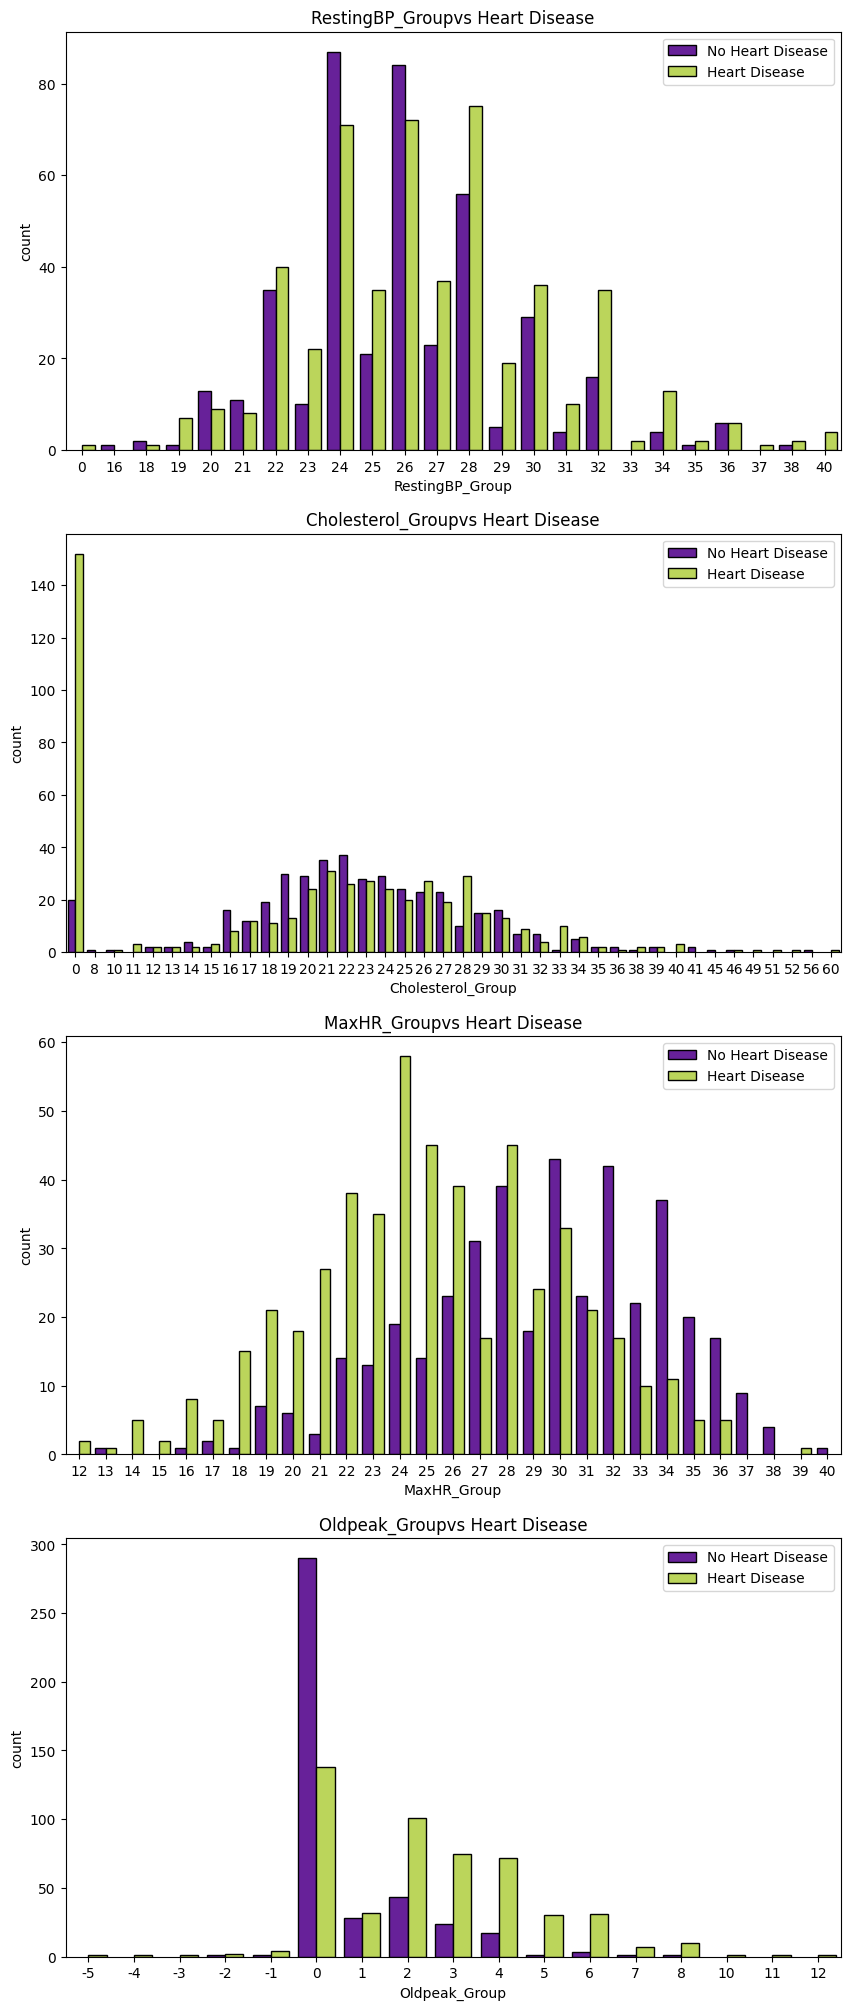

In [19]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (10, 25))
group_numerical_features = [i + '_Group' for i in numerical_features[1:]]
for i in range(len(group_numerical_features)):
    plt.subplot(4, 1, i+1)
    sns.countplot(x = group_numerical_features[i], data = data, hue = 'HeartDisease', palette = colors, edgecolor = 'black')
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = group_numerical_features[i] + 'vs Heart Disease'
    plt.title(title)

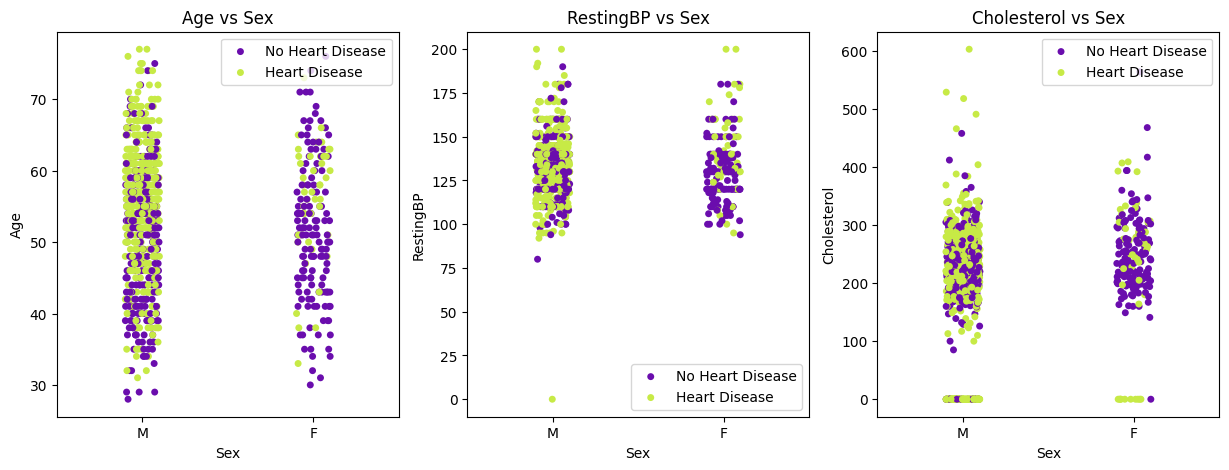

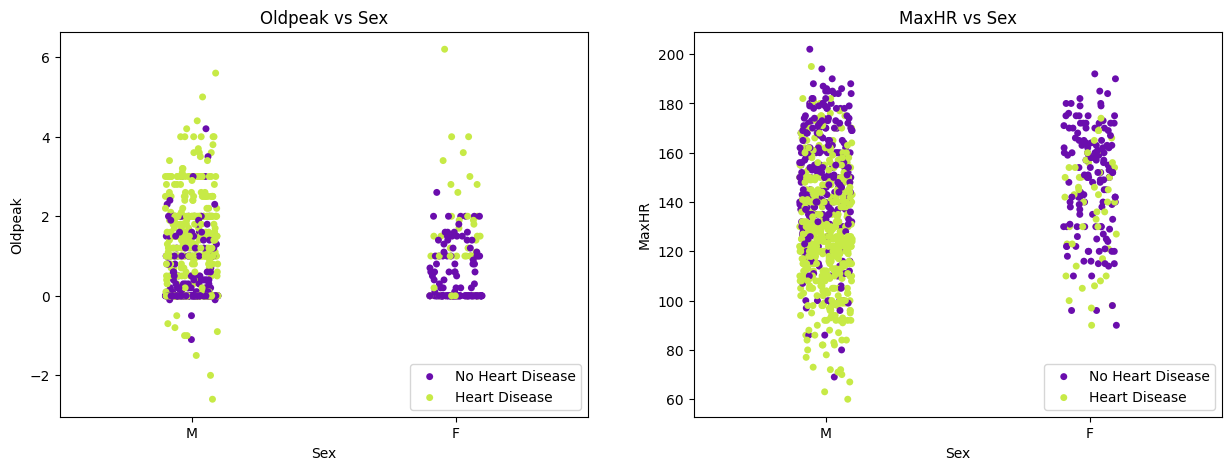

In [20]:
fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.stripplot(x = 'Sex',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs Sex' 
    plt.title(title)

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))
for i in [-1,-2]:
    plt.subplot(1,2,-i)
    sns.stripplot(x = 'Sex',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs Sex' 
    plt.title(title)

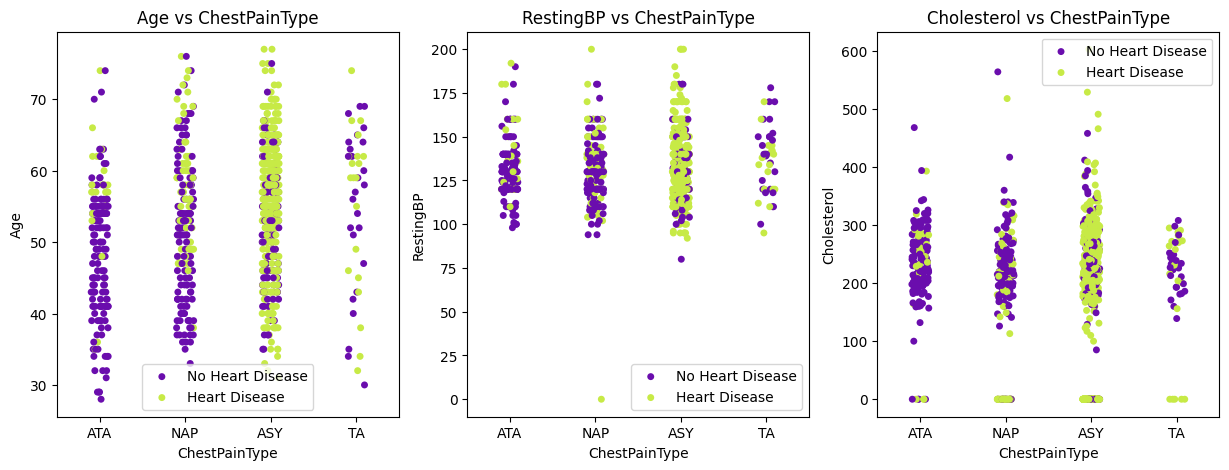

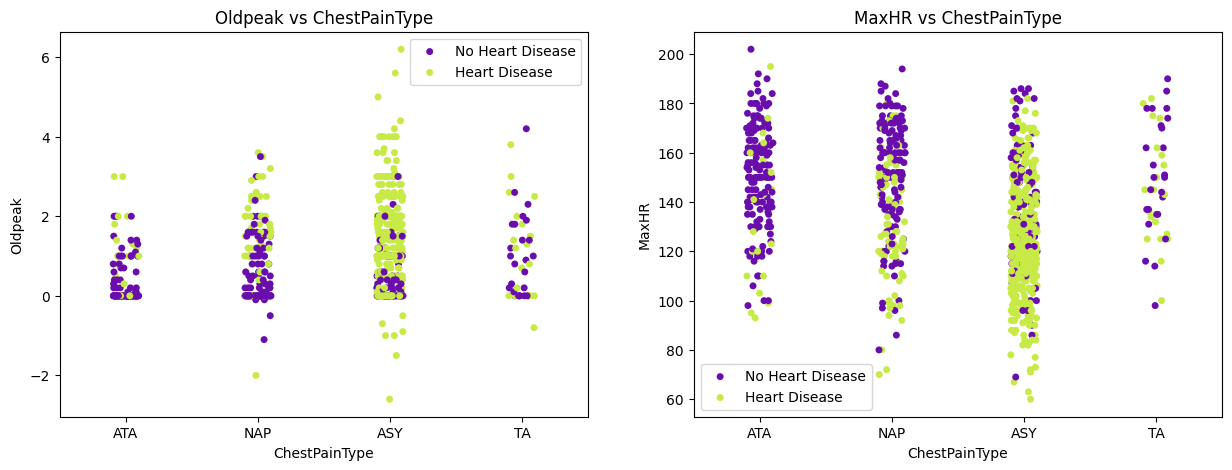

In [21]:
fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.stripplot(x = 'ChestPainType',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs ChestPainType'
    plt.title(title)

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))
for i in [-1,-2]:
    plt.subplot(1,2,-i)
    sns.stripplot(x = 'ChestPainType',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs ChestPainType' 
    plt.title(title)

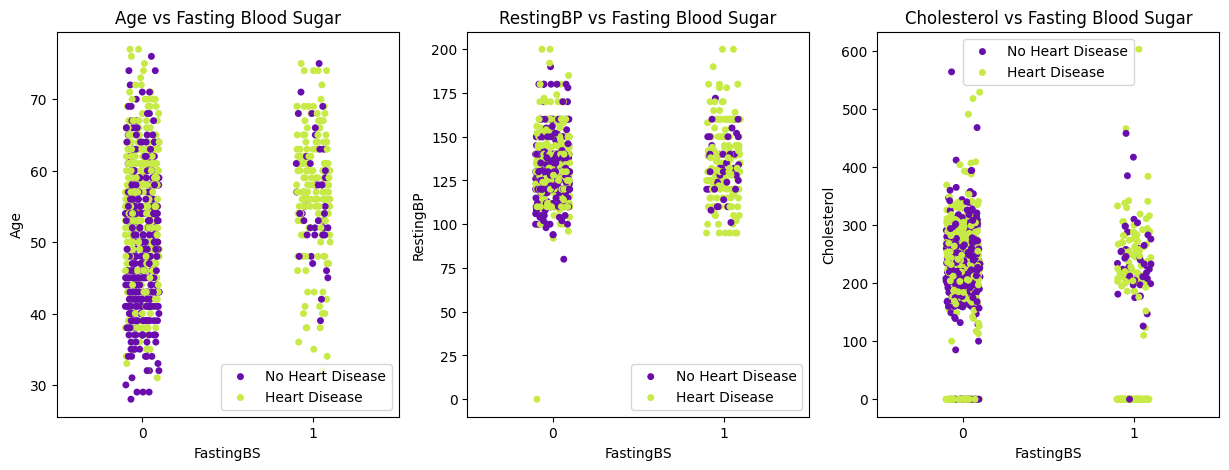

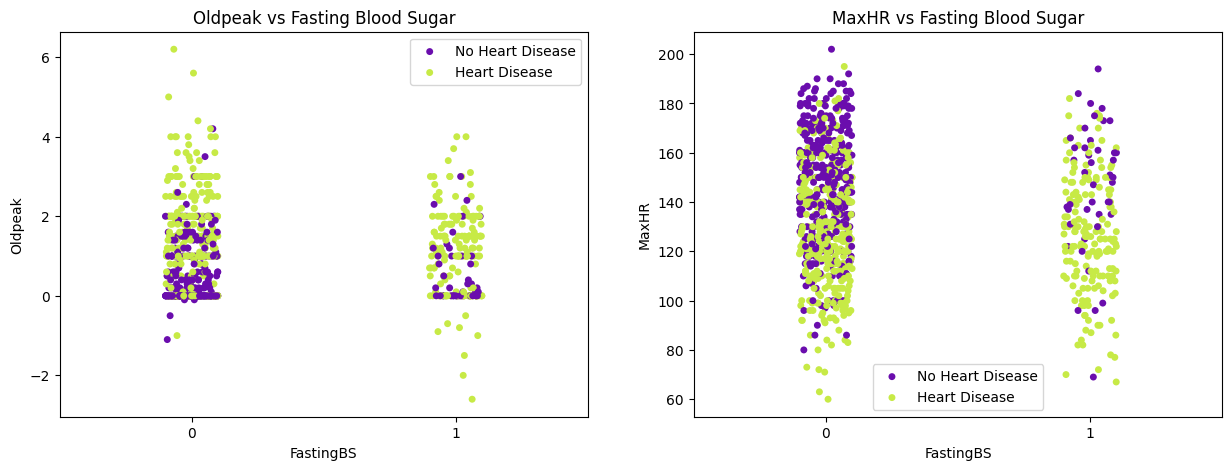

In [22]:
fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.stripplot(x = 'FastingBS',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs Fasting Blood Sugar' 
    plt.title(title)

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))
for i in [-1,-2]:
    plt.subplot(1,2,-i)
    sns.stripplot(x = 'FastingBS',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs Fasting Blood Sugar' 
    plt.title(title)

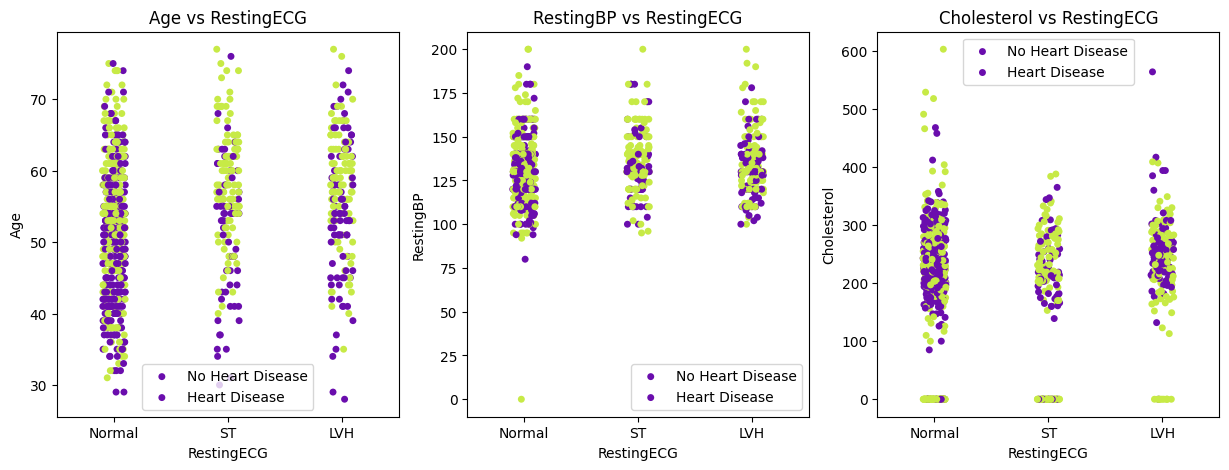

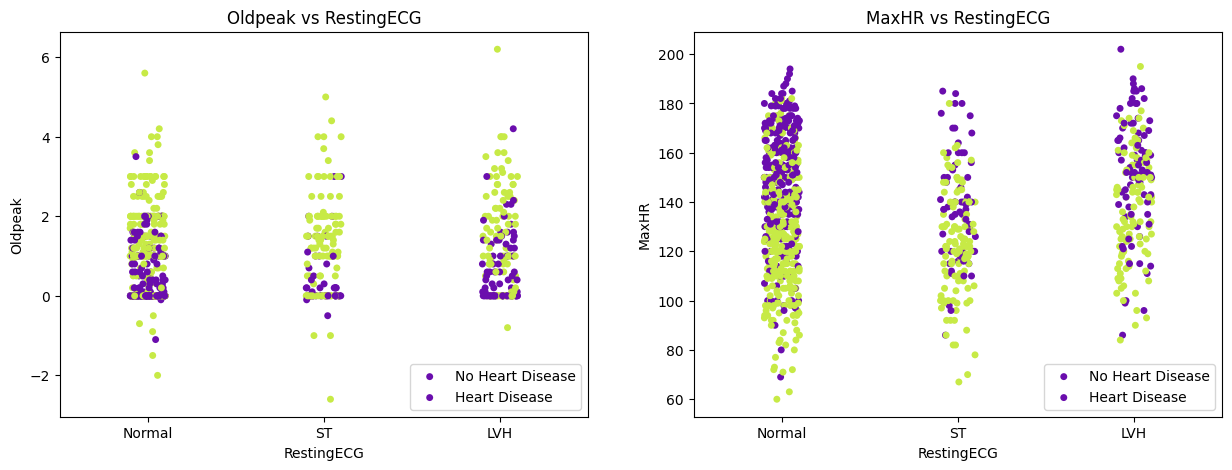

In [23]:
fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.stripplot(x = 'RestingECG',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs RestingECG' 
    plt.title(title)

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))
for i in [-1,-2]:
    plt.subplot(1,2,-i)
    sns.stripplot(x = 'RestingECG',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs RestingECG'
    plt.title(title)

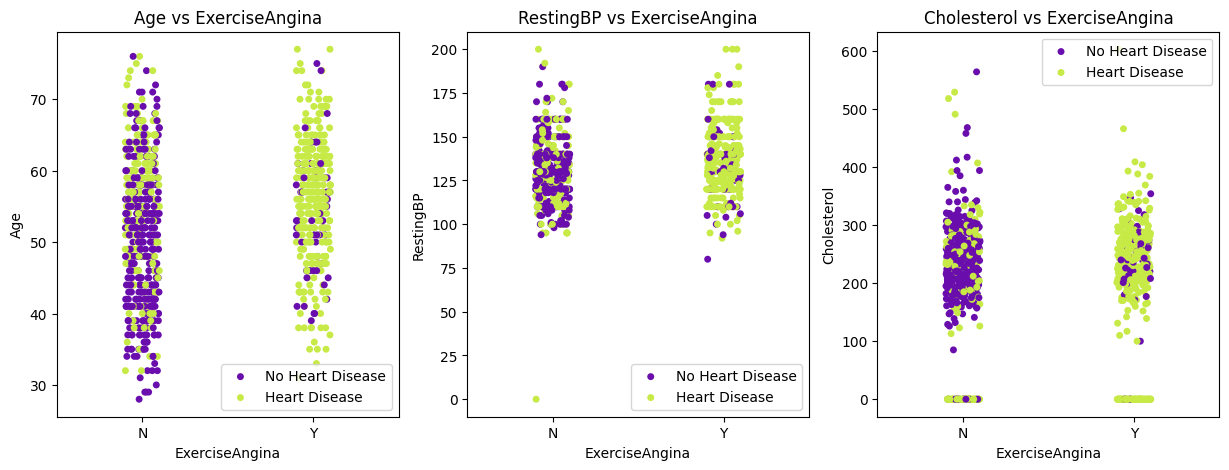

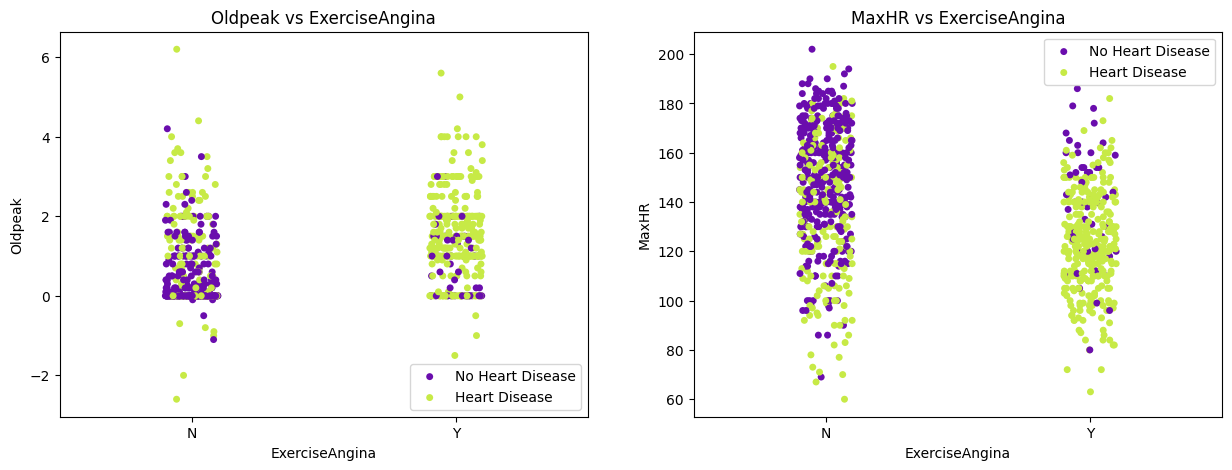

In [24]:
fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.stripplot(x = 'ExerciseAngina',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs ExerciseAngina'
    plt.title(title)

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))
for i in [-1,-2]:
    plt.subplot(1,2,-i)
    sns.stripplot(x = 'ExerciseAngina',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs ExerciseAngina' 
    plt.title(title)

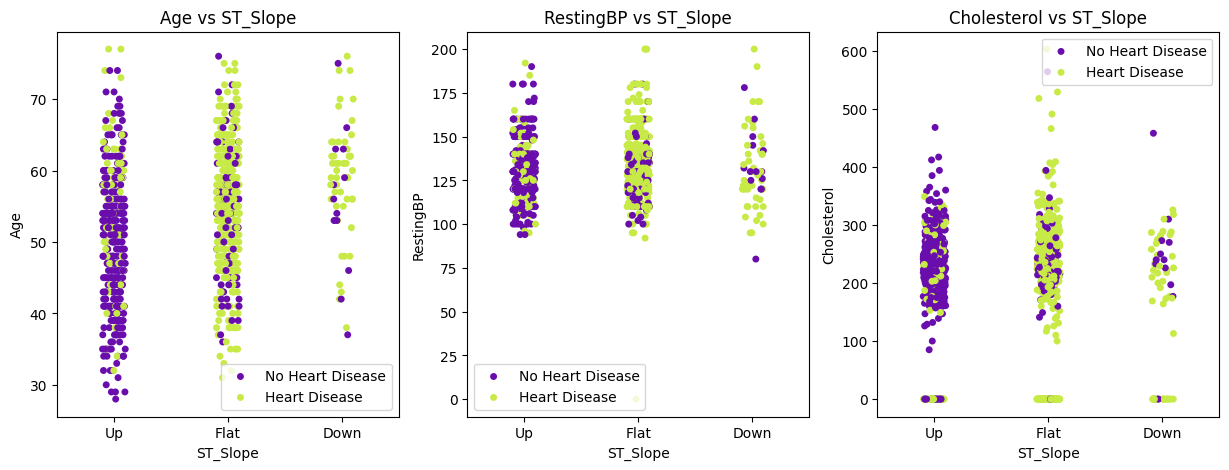

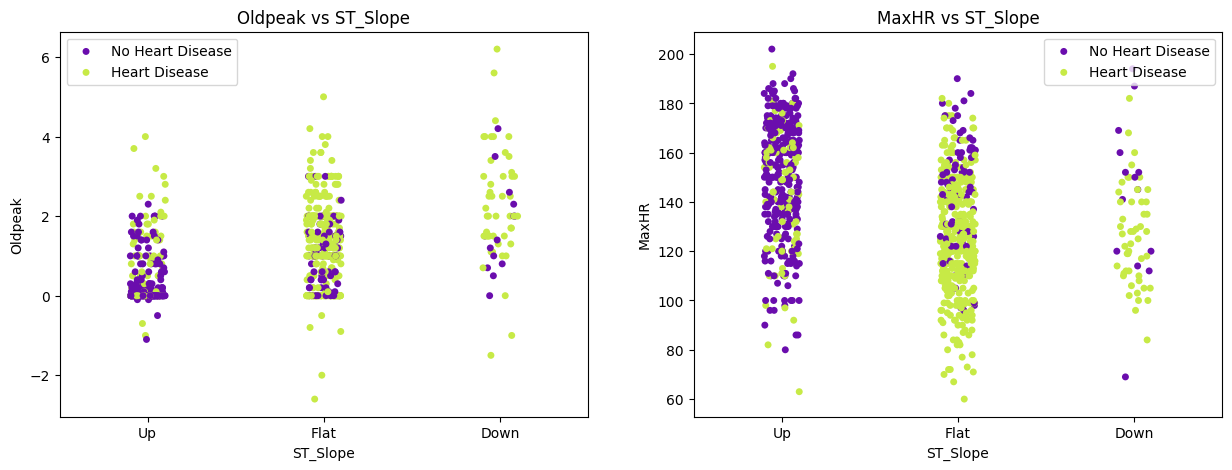

In [25]:
fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.stripplot(x = 'ST_Slope',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs ST_Slope' 
    plt.title(title)

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))
for i in [-1,-2]:
    plt.subplot(1,2,-i)
    sns.stripplot(x = 'ST_Slope',y = numerical_features[i],data = data,hue = 'HeartDisease',palette = colors);
    plt.legend(['No Heart Disease', 'Heart Disease'])
    title = numerical_features[i] + ' vs ST_Slope'
    plt.title(title)

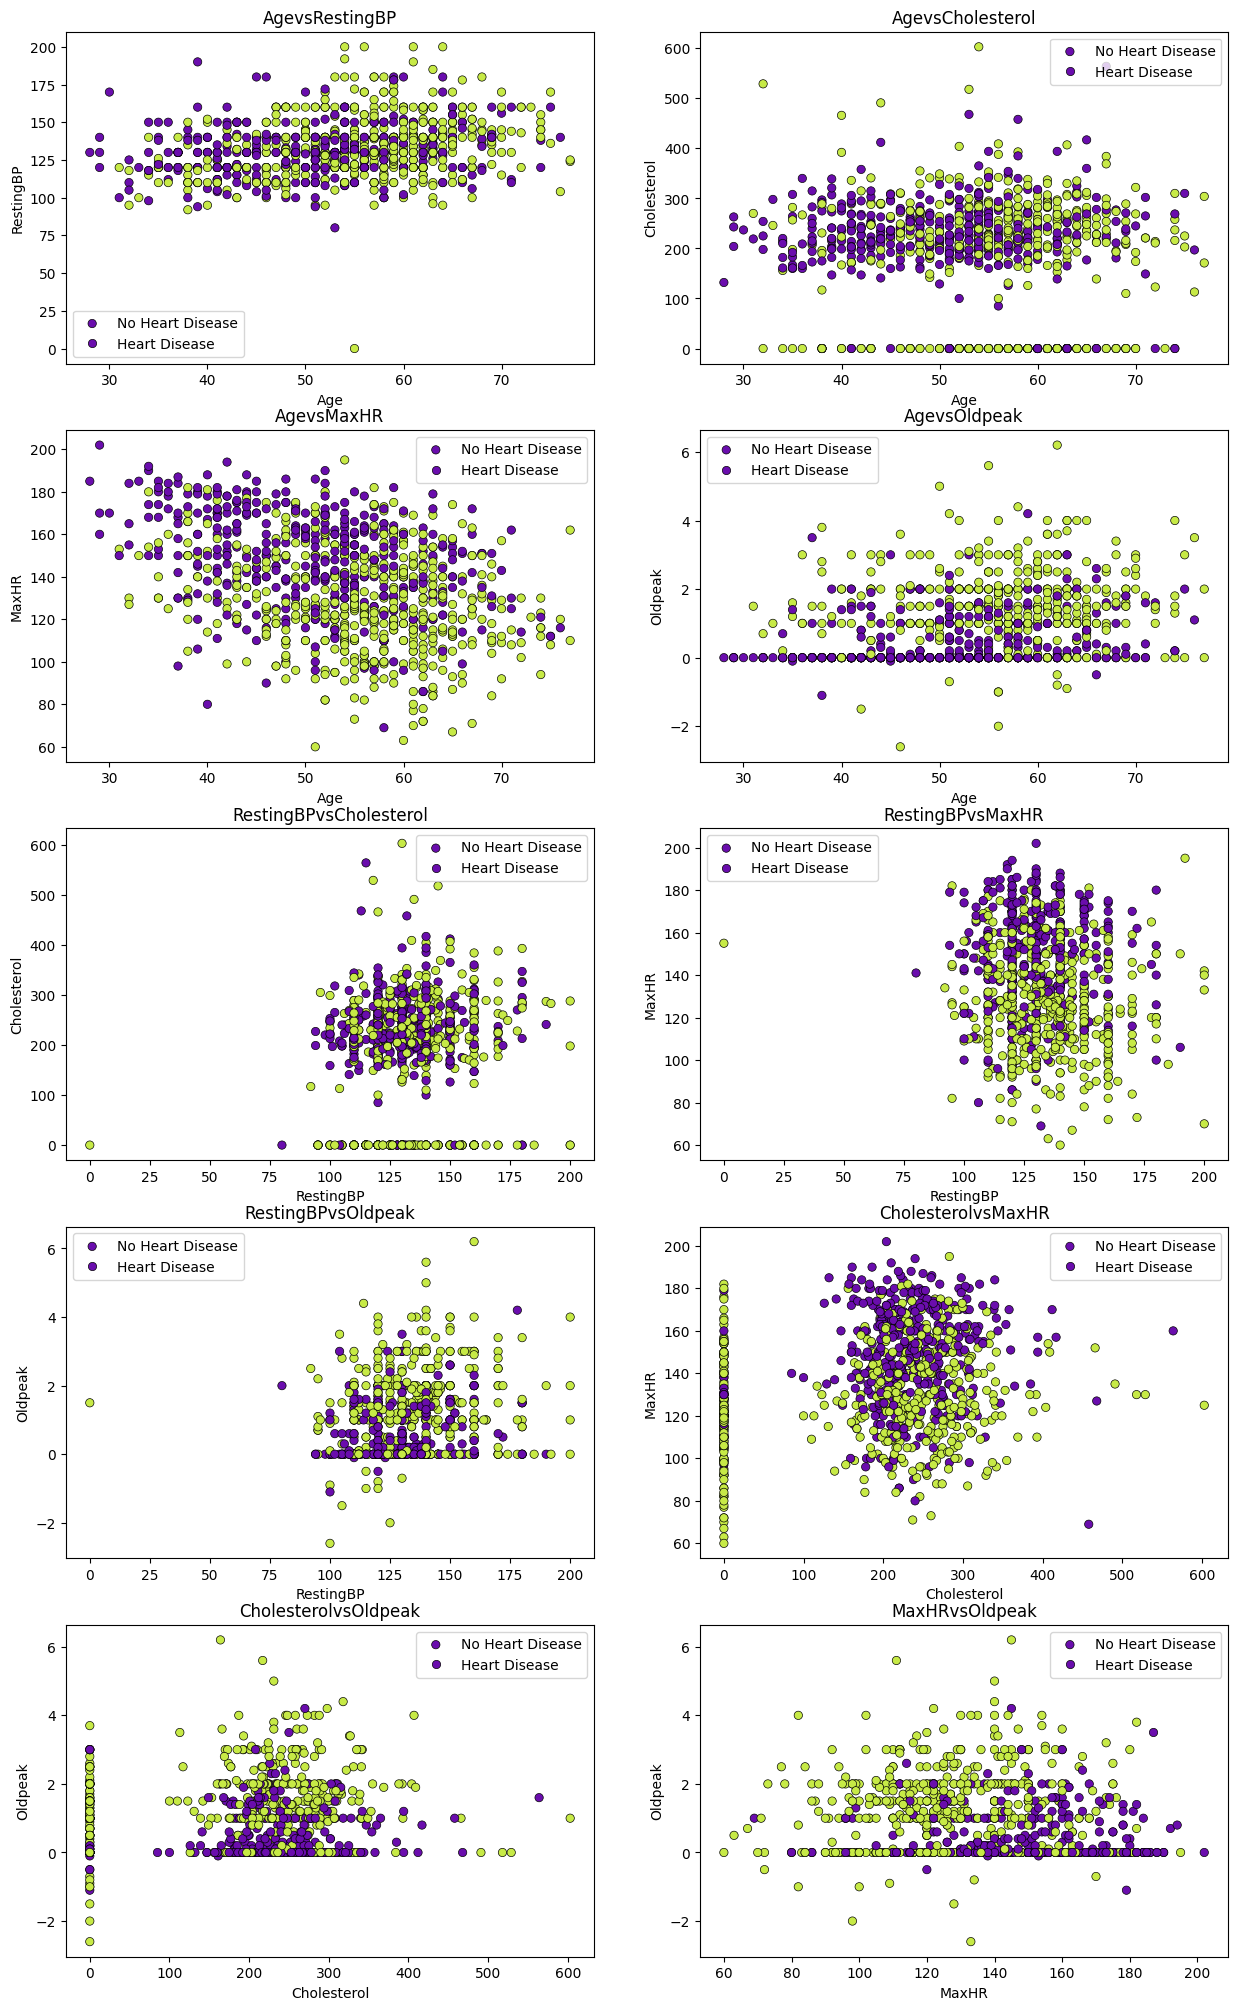

In [26]:
a = 0
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (15, 25))
for i in range(len(numerical_features)):
    for j in range(len(numerical_features)):
        if i != j and j > i:
            a += 1
            plt.subplot(5, 2, a)
            sns.scatterplot(x = numerical_features[i], y =numerical_features[j], data = data, hue = 'HeartDisease', palette = colors, edgecolor = 'black')
            plt.legend(['No Heart Disease', 'Heart Disease'])
            title = numerical_features[i] + ' vs ' + numerical_features[j]
            plt.title(title)

In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mms = MinMaxScaler()
ss = StandardScaler()

df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])
df1.head()

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0 -1.43    1              1       0.41         0.83          0           1   
1 -0.48    0              2       1.49        -0.17          0           1   
2 -1.75    1              1      -0.13         0.77          0           2   
3 -0.58    0              0       0.30         0.14          0           1   
4  0.05    1              2       0.95        -0.03          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0   1.38               0     0.30         2             0  
1   0.75               0     0.41         1             1  
2  -1.53               0     0.30         2             0  
3  -1.13               1     0.47         1             1  
4  -0.58               0     0.30         2             0

<Axes: >

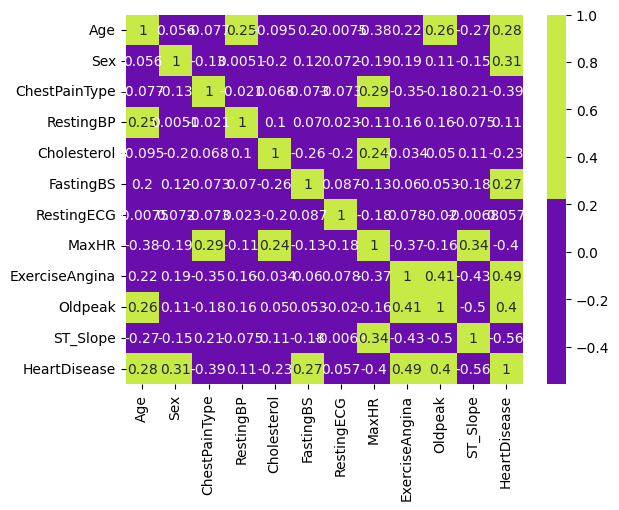

In [28]:
plt.figure(figure = (20, 5))
sns.heatmap(df1.corr(), cmap = colors, annot = True)

Text(0.5, 1.0, 'Correlation w.r.t HeartDisease')

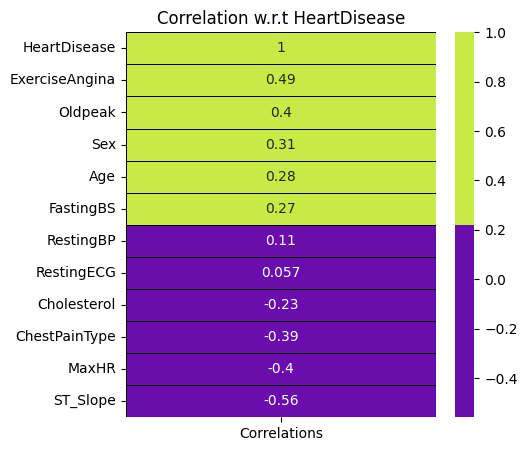

In [29]:
corr = df1.corrwith(df1['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr, annot= True, cmap = colors, linewidths = 0.4, linecolor= 'black')
plt.title('Correlation w.r.t HeartDisease')

In [30]:
from sklearn.feature_selection import SelectKBest, chi2

Text(0.5, 1.0, 'Selection of Categorical Features')

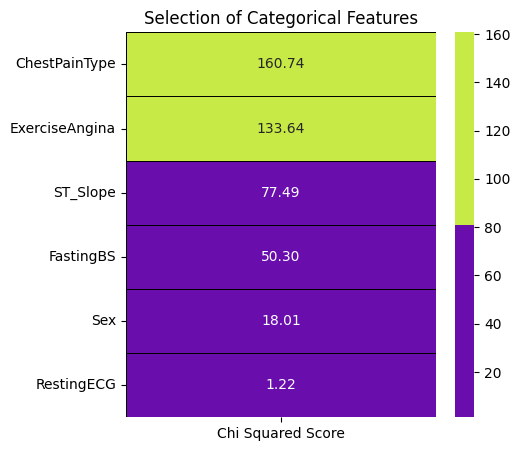

In [31]:
features = df1.loc[:,categorical_features[:-1]]
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features')

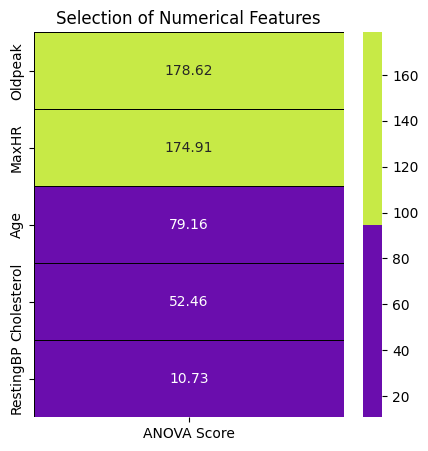

In [32]:
from sklearn.feature_selection import f_classif

features = df1.loc[:,numerical_features]
target = df1.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [34]:
features =df1[df1.columns.drop(['HeartDisease', 'RestingBP', 'RestingECG'])].values
target = df1['HeartDisease'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=2)

In [78]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve_manual(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [79]:
def model(classifier):
    classifier.fit(x_train, y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    print("Accuracy: ",'{0:.2%}'.format(accuracy_score(y_test, prediction)))
    print("Cross Validation Score: ",'{0:.2%}'.format(cross_val_score(classifier, x_train, y_train, cv = cv, scoring='roc_auc').mean()))
    print("ROC_AUC Score: ", '{0:.2%}'.format(roc_auc_score(y_test, prediction)))
    RocCurveDisplay.from_estimator(classifier, x_test, y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

def model_evaluation(classifier):
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = colors,fmt ='')
    
    print(classification_report(y_test,classifier.predict(x_test)))

## KNN

In [70]:
from supervised_learning.knn import KNN
from sklearn.neighbors import KNeighborsClassifier


In [71]:
classifier_knn = KNeighborsClassifier(leaf_size = 1, n_neighbors = 3,p = 1)
classifier_knn_manual = KNN(n_neighbors=3, metric='manhattan', p=1)

Accuracy:  81.52%
ROC_AUC Score:  81.36%


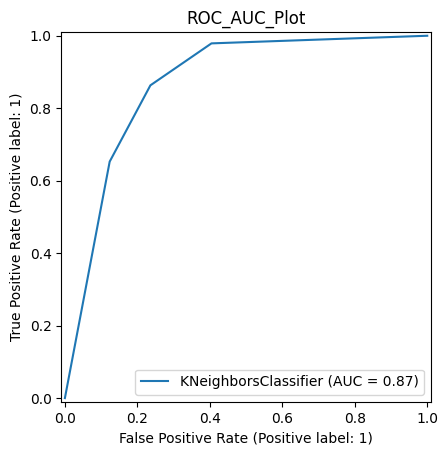

In [76]:
model(classifier_knn)

In [ ]:
model(classifier_knn_manual)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [37]:
classifier_lr = LogisticRegression(random_state = 0,C=10,penalty= 'l2') 

## Gaussian Naive Bayes

In [1]:
from sklearn.naive_bayes import GaussianNB

## CART (Classification and Regression Tree)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

## SVM (Support Vector Machine)

In [ ]:
from sklearn.svm import SVC

## ANN (Artificial Neural Network)

In [2]:
import tensorflow as tf

Accuracy:  87.50%
Cross Validation Score:  91.11%
ROC_AUC Score:  87.43%


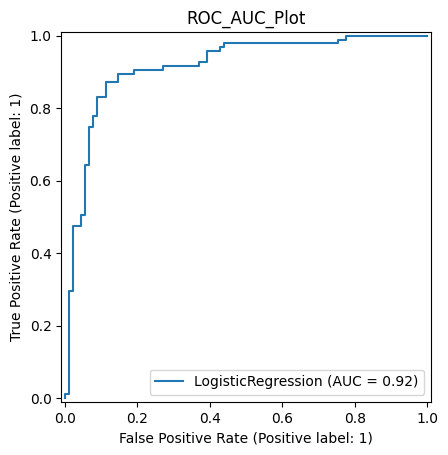

In [38]:
model(classifier_lr)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        89
           1       0.87      0.89      0.88        95

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



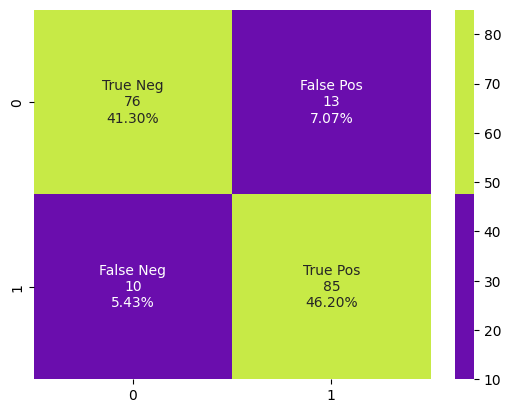

In [39]:
model_evaluation(classifier_lr)

In [40]:
from sklearn.svm import SVC

In [41]:
classifier_svc = SVC(kernel = 'linear',C = 0.1)

Accuracy:  87.50%
Cross Validation Score:  90.53%
ROC_AUC Score:  87.43%


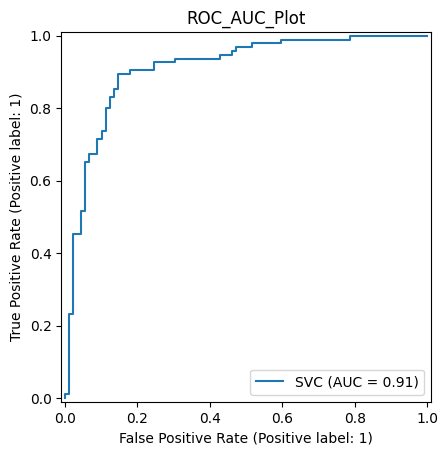

In [42]:
model(classifier_svc)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        89
           1       0.87      0.89      0.88        95

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



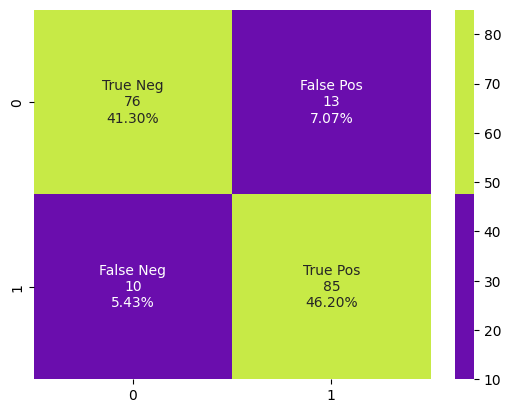

In [43]:
model_evaluation(classifier_svc)

In [44]:
from sklearn.tree import DecisionTreeClassifier

In [45]:
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)

Accuracy:  84.78%
Cross Validation Score:  89.09%
ROC_AUC Score:  84.62%


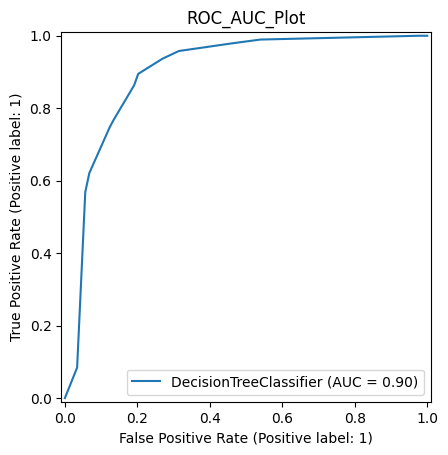

In [46]:
model(classifier_dt)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        89
           1       0.83      0.89      0.86        95

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



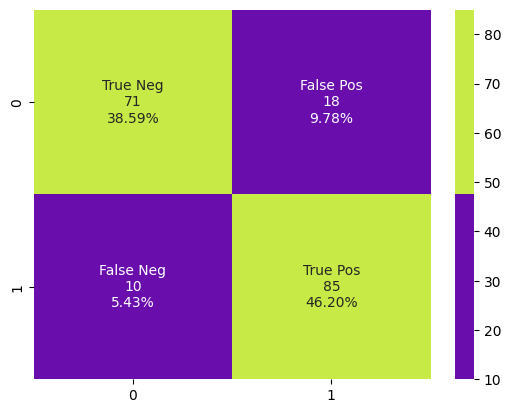

In [47]:
model_evaluation(classifier_dt)

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)

Accuracy:  84.24%
Cross Validation Score:  92.91%
ROC_AUC Score:  84.06%


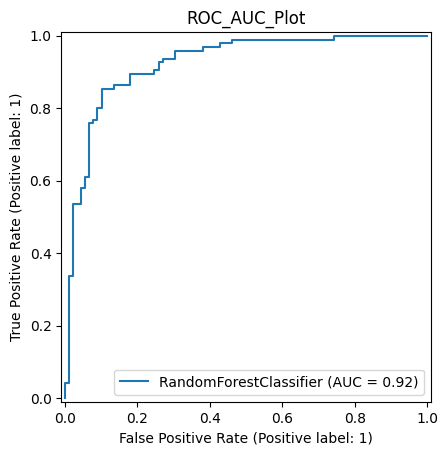

In [50]:
model(classifier_rf)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        89
           1       0.82      0.89      0.85        95

    accuracy                           0.84       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184



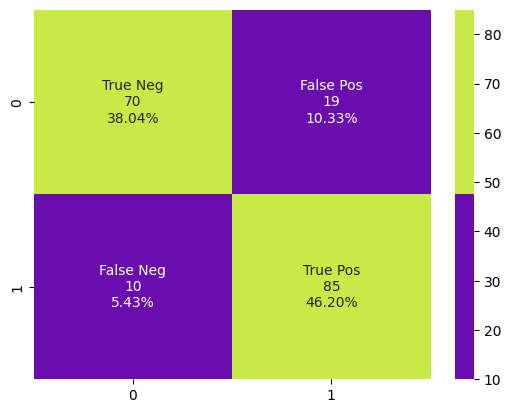

In [51]:
model_evaluation(classifier_rf)

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
classifier_knn = KNeighborsClassifier(leaf_size = 1, n_neighbors = 3,p = 1)

Accuracy:  81.52%
Cross Validation Score:  89.34%
ROC_AUC Score:  81.36%


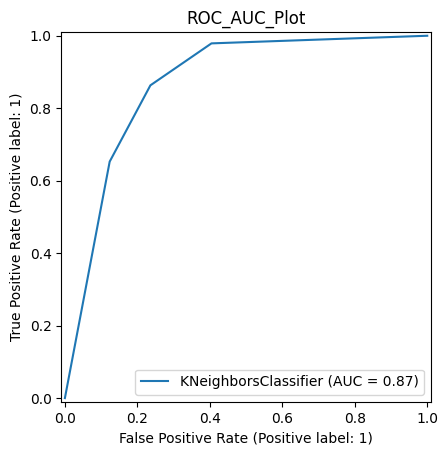

In [54]:
model(classifier_knn)

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        89
           1       0.80      0.86      0.83        95

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184



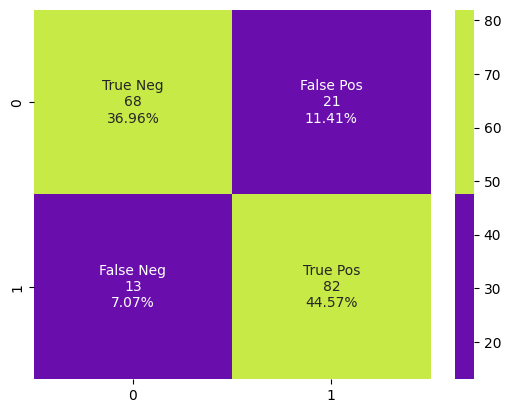

In [55]:
model_evaluation(classifier_knn)